In [1]:
!pip install -q tiktoken datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import pytz
from datetime import datetime
import tiktoken
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from torch.utils.data import IterableDataset, DataLoader
from datasets import load_dataset, load_from_disk
from typing import Optional

In [3]:
class Config:
    def __init__(self):
        enc = tiktoken.get_encoding("gpt2")

        self.tokenizer                  = enc
        self.eot_token                  = enc.eot_token
        self.pad_token                  = enc.n_vocab
        self.vocab_size                 = enc.n_vocab + 1
        self.min_sequence_length        = 128
        self.dimension                  = 512
        self.block_size                 = 512
        self.block_stride               = 512
        self.max_blocks_per_example     = 4
        self.num_layers                 = 16
        self.num_heads                  = 8
        self.dropout_attention          = 0.0
        self.dropout_multihead          = 0.01 #0.05 #0.01 #0.1 # changed for epoch 3
        self.dropout_ff_fc              = 0.0
        self.dropout_ff_proj            = 0.01 #0.05
        self.device                     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lr                         = 1e-4 #0.0003 #1e-4 #0.000135 #0.00015 #0.0002 #0.0003
        self.lr_min                     = 3e-5 #1e-6 #0.00003 #1e-6 #2e-6 #0.00001
        self.lr_warmup_steps            = 20000 #2000 #20000 #1000 #500
        self.grad_norm_clip_value       = 1.5 #1.0 #0.3 #0.4
        self.optimizer_betas            = (0.9, 0.999) #(0.9, 0.95)
        self.optimizer_eps              = 1e-8
        self.optimizer_weight_decay     = 0.01 #0.02 #0.01 #0.1 # changed for epoch 3
        self.batch_size                 = 32
        self.max_epochs                 = 4
        self.total_steps                = 253911 #438_750 #453_125 #618_125  # NOTE: 255911 is a per-epoch number; for cosine decay.
        self.train_print_interval       = 250
        self.train_print_ema_beta       = 0.998 #0.995 #0.998 #0.98 #0.95
        self.checkpoint_directory       = "/content/drive/My Drive/" #"/home/sagemaker-user/"
        self.checkpoint_interval        = 5000
        self.checkpoint_copy_interval   = 10000
        self.validation_interval        = 1000
        self.validation_max_steps       = 2

    def __repr__(self):
        return "Configuration values:\n" + \
            "\n".join([f"  {p.__repr__()}: {getattr(self, p)}" for p in dir(self) if not p.startswith("__") and not p.startswith("_")])


def init_model(config):
    torch.manual_seed(99)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(99)
    torch.set_float32_matmul_precision('high')
    model = Model(config)
    #model = torch.compile(model)
    return model.to(config.device)


def init_weights(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)


class AttentionHead(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_dimension  = config.dimension // config.num_heads

        self.query        = nn.Linear(config.dimension, head_dimension)
        self.key          = nn.Linear(config.dimension, head_dimension, bias=False)
        self.value        = nn.Linear(config.dimension, head_dimension)
        self.scale        = 1.0 / (head_dimension ** 0.5)
        self.attn_dropout = nn.Dropout(config.dropout_attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size, device=config.device)))

    def forward(self, x, padding_mask: Optional[Tensor] = None):
        B, T, C = x.shape
        assert T <= self.config.block_size, f"Input sequence length {T} exceeds block size {self.config.block_size}."

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        if padding_mask is not None:
            padding_mask = padding_mask[:, None, :T].bool().expand(B, T, T)

        causal_mask = self.tril[:T, :T].bool()[None, :, :]

        if padding_mask is not None:
            combined_mask = causal_mask & padding_mask
        else:
            combined_mask = causal_mask

        attention_scores  = (Q @ K.transpose(-2, -1)) * self.scale
        attention_scores  = attention_scores.masked_fill(~combined_mask, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attn_dropout(attention_weights)
        output = attention_weights @ V

        return output


class MultiHeadAttention(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.dimension % config.num_heads == 0, f"Embedding dimension {config.dimension} is not divisible by number of heads {config.num_heads}."

        self.heads    = nn.ModuleList([AttentionHead(config) for _ in range(config.num_heads)])
        self.proj     = nn.Linear(config.dimension, config.dimension)
        self.dropout  = nn.Dropout(config.dropout_multihead)

    def forward(self, x, padding_mask: Optional[Tensor] = None):
        head_outputs  = [head(x, padding_mask) for head in self.heads]
        output        = torch.cat(head_outputs, dim=-1)
        output        = self.proj(output)
        return self.dropout(output)


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.dimension, 4 * config.dimension),
            nn.GELU(),
            nn.Dropout(config.dropout_ff_fc),
            nn.Linear(4 * config.dimension, config.dimension),
            nn.Dropout(config.dropout_ff_proj)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1  = nn.LayerNorm(config.dimension)
        self.attn = MultiHeadAttention(config)
        self.ln2  = nn.LayerNorm(config.dimension)
        self.ff   = FeedForward(config)

    def forward(self, x, padding_mask):
        x = x + self.attn(self.ln1(x), padding_mask)
        return x + self.ff(self.ln2(x))


class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config             = config
        self.token_embedding    = nn.Embedding(config.vocab_size, config.dimension, padding_idx=config.pad_token)
        self.position_embedding = nn.Embedding(config.block_size, config.dimension)
        self.blocks             = nn.ModuleList([Block(config) for _ in range(config.num_layers)])
        self.ln_f               = nn.LayerNorm(config.dimension)
        self.lm_head            = nn.Linear(config.dimension, config.vocab_size)

    def forward(self, idx, targets=None, padding_mask: Optional[Tensor] = None):
        _, T = idx.shape
        assert T <= self.config.block_size, f"Input sequence length {T} exceeds block size {self.config.block_size}."

        token_emb = self.token_embedding(idx)
        pos       = torch.arange(T, device=self.config.device)
        pos_emb   = self.position_embedding(pos).unsqueeze(0)
        x         = token_emb + pos_emb

        for block in self.blocks:
            x = block(x, padding_mask)

        x         = self.ln_f(x)
        logits    = self.lm_head(x)

        loss = None
        if targets is not None:
            logits  = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss    = F.cross_entropy(logits, targets, ignore_index=self.config.pad_token)

        return logits, loss

    def generate(self, input_ids, max_new_tokens, temperature=0.7, top_p=0.9, top_k=50):
        if temperature < 0:
            raise ValueError(f"`temperature` must be ≥ 0, got {temperature}")
        if max_new_tokens < 1:
            raise ValueError(f"`max_new_tokens` must be ≥ 1, got {max_new_tokens}")

        input_ids     = input_ids.to(self.config.device)
        input_ids     = input_ids.unsqueeze(0) if input_ids.dim() == 1 else input_ids
        was_training  = self.training
        self.eval()

        with torch.no_grad():
            for _ in range(max_new_tokens):
                input_ids   = input_ids[:, -self.config.block_size:]
                logits, _   = self(input_ids)
                logits      = logits[:, -1, :]

                if temperature == 0:
                    next_token  = torch.argmax(logits, dim=-1, keepdim=True)
                else:
                    logits      = logits / temperature
                    if top_k is not None and top_k < logits.size(-1):
                        logits  = self.top_k_filter(logits, top_k=top_k)
                    logits      = self.top_p_filter(logits, top_p=top_p)
                    probs       = F.softmax(logits, dim=-1)
                    next_token  = torch.multinomial(probs, num_samples=1)

                input_ids = torch.cat((input_ids, next_token), dim=1)

        if was_training:
            self.train()

        return input_ids

    def top_k_filter(self, logits, top_k, filter_value=-float("Inf")):
        topk_logits, topk_indices = torch.topk(logits, top_k, dim=-1)
        mask = logits < topk_logits[..., -1, None]
        return logits.masked_fill(mask, filter_value)

    def top_p_filter(self, logits, top_p=0.9, filter_value=-float('Inf')):
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        probs = F.softmax(sorted_logits, dim=-1)
        cumulative_probs = torch.cumsum(probs, dim=-1)
        mask = cumulative_probs > top_p
        mask[..., 1:] = mask[..., :-1].clone()
        mask[..., 0] = False
        mask = mask.scatter(dim=-1, index=sorted_indices, src=mask)
        return logits.masked_fill(mask, filter_value)


class StreamedDataset(IterableDataset):
    def __init__(self, config, dataset, position=0):
        self.config   = config
        self.dataset  = dataset
        self.position = position
        if position > 0:
            self.dataset = dataset.skip(position)
            print(f"Skipped {position} examples already seen this epoch.")
        self.full_block_mask = torch.ones(self.config.block_size, dtype=torch.long)

    def __iter__(self):
        for _, example in enumerate(self.dataset):
            self.position += 1
            text = example.get("text", "")

            if not text:
                continue

            if len(text) // 4 < self.config.min_sequence_length:
                continue

            tokens      = self.config.tokenizer.encode(text) + [self.config.eot_token]
            block_size  = self.config.block_size
            stride      = self.config.block_stride
            pad_token   = self.config.pad_token
            seq_length  = len(tokens)

            if seq_length >= block_size + 1:
                block_count = 0
                for start in range(0, seq_length - (block_size + 1) + 1, stride):
                    if block_count >= self.config.max_blocks_per_example:
                        break
                    window = tokens[start : start + block_size + 1]
                    x = window[:block_size]
                    y = window[1:]
                    yield {
                        "x": torch.tensor(x, dtype=torch.long),
                        "y": torch.tensor(y, dtype=torch.long),
                        "padding_mask": self.full_block_mask
                    }
                    block_count += 1
            else:
                x = tokens[:]
                y = tokens[1:]
                pad_length = block_size - seq_length
                padding_mask = [1] * seq_length + [0] * pad_length
                x = x + [pad_token] * pad_length
                y = y + [pad_token] * (pad_length + 1)
                yield {
                    "x": torch.tensor(x, dtype=torch.long),
                    "y": torch.tensor(y, dtype=torch.long),
                    "padding_mask": torch.tensor(padding_mask, dtype=torch.long)
                }


class Trainer():
    def __init__(self, config):
        self.config = config
        persistent_checkpoints_directory = self.config.checkpoint_directory + "checkpoints"
        os.makedirs(persistent_checkpoints_directory, exist_ok=True)

    def init_optimizer(self, model):
        return AdamW(model.parameters(),
                     lr = self.config.lr,
                     betas = self.config.optimizer_betas,
                     eps = self.config.optimizer_eps,
                     weight_decay = self.config.optimizer_weight_decay)

    def init_scheduler(self, optimizer, last_step=-1):
        #NOTE: this is temp
        #last_step = 14914
        #warmup_scheduler  = LinearLR(optimizer,
        #                             start_factor=0.3,
        #                             end_factor=1.0,
        #                             total_iters=self.config.lr_warmup_steps)
        cosine_scheduler  = CosineAnnealingLR(optimizer,
                                              T_max=self.config.total_steps,
                                              eta_min=self.config.lr_min,
                                              last_epoch=last_step)
        #return SequentialLR(optimizer,
        #                    schedulers=[warmup_scheduler, cosine_scheduler],
        #                    milestones=[self.config.lr_warmup_steps])

        return cosine_scheduler

    def init_dataset(self, dataset_position):
        # TODO: need a good dataset for validation, or split the main ds
        #dataset                 = load_from_disk("wiki").to_iterable_dataset()
        #num_examples            = 6407814
        #num_examples_val        = 10
        #num_examples_train      = num_examples - num_examples_val
        #dataset_train           = dataset.take(num_examples_train)
        #dataset_val             = dataset.skip(num_examples_train)

        dataset_train           = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", streaming=True, trust_remote_code=True)
        streamed_dataset_train  = StreamedDataset(self.config, dataset_train, position=dataset_position)

        return streamed_dataset_train, None

    def train(self, model):
        optimizer           = self.init_optimizer(model)
        scheduler           = self.init_scheduler(optimizer)
        losses, grad_norms  = self.load_train_metrics()
        last_epoch, last_step, loss_ema, dataset_position = self.load_checkpoint(model, optimizer, scheduler)

        start_epoch = last_epoch
        start_step  = last_step + 1

        # NOTE - This is a temporary hack.
        #        Remember to comment it out before the next resume!
        #start_epoch = 3
        #start_step  = 0
        #dataset_position = 0

        # NOTE - This is a temporary hack.
        #        Remember to comment it out before the next resume!
        #for pg in optimizer.param_groups:
            #pg['lr'] = 0.000047 #self.config.lr
            #pg['weight_decay'] = self.config.optimizer_weight_decay
        #scheduler = self.init_scheduler(optimizer)

        model.train()

        try:
            for epoch in range(start_epoch, self.config.max_epochs):
                if epoch > start_epoch:
                    start_step = 0
                    dataset_position = 0

                print(f'\nStarting epoch {epoch + 1} at step {start_step + 1}.')

                streamed_dataset_train, streamed_dataset_val  = self.init_dataset(dataset_position)
                dataloader_train  = DataLoader(streamed_dataset_train, batch_size=self.config.batch_size)
                dataloader_val    = None if streamed_dataset_val is None else DataLoader(streamed_dataset_val, batch_size=self.config.batch_size)

                for step, batch in enumerate(dataloader_train, start=start_step):
                    xb = batch["x"].to(self.config.device)
                    yb = batch["y"].to(self.config.device)
                    padding_mask = batch["padding_mask"].to(self.config.device)

                    _, loss = model(xb, yb, padding_mask)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    norm = nn.utils.clip_grad_norm_(model.parameters(), self.config.grad_norm_clip_value)
                    optimizer.step()
                    scheduler.step()
                    losses.append(loss.item())
                    grad_norms.append(norm.item())

                    if loss_ema is None:
                        loss_ema = loss.item()
                    else:
                        loss_ema = loss_ema * self.config.train_print_ema_beta + (1 - self.config.train_print_ema_beta) * loss.item()

                    now = datetime.now(pytz.timezone('America/New_York')).strftime('%m %d %I:%M %p')

                    if (step + 1) % self.config.checkpoint_interval == 0:
                        self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position)
                        self.save_train_metrics(losses, grad_norms)

                    if (step + 1) % self.config.checkpoint_copy_interval == 0:
                        self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position, file_name=f"checkpoints/checkpoint-{now}.pt")
                        self.save_train_metrics(losses, grad_norms, file_name=f"checkpoints/train-metrics-{now}.pt")

                    if step == 0 or (step + 1) % self.config.train_print_interval == 0:
                        lr = optimizer.param_groups[0]['lr']
                        print(f"{now} | Epoch: {epoch + 1} | Step: {step + 1} | Train Loss EMA: {loss.item():.2f} | LR: {lr:.6f} | Grad Norm: {norm:.2f}")

                    if dataloader_val is not None:
                        if (step + 1) % self.config.validation_interval == 0:
                            self.validate(model, dataloader_val, step)
                            model.train()

                self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, streamed_dataset_train.position, file_name=f"checkpoints/checkpoint-epoch-{epoch + 1}-final.pt")
                self.save_train_metrics(losses, grad_norms, file_name=f"checkpoints/train-metrics-epoch-{epoch + 1}-final.pt")
                print(f"Epoch {epoch + 1} completed.")
        except KeyboardInterrupt:
            if 'streamed_dataset_train' in locals():
                dataset_position = streamed_dataset_train.position
            self.save_checkpoint(model, optimizer, scheduler, epoch, step, loss_ema, dataset_position, 'checkpoint-interruptted.pt')
            self.save_train_metrics(losses, grad_norms, 'train-metrics-interruptted.pt')
            print("Training interrupted. Model saved.")

    def validate(self, model, dataloader_val, train_step):
        total_val_loss  = 0.0
        num_val_steps   = 0
        val_losses = self.load_val_metrics()

        model.eval()

        with torch.no_grad():
            for step, batch in enumerate(dataloader_val):
                if step >= self.config.validation_max_steps:
                    break

                xb            = batch["x"].to(self.config.device)
                yb            = batch["y"].to(self.config.device)
                padding_mask  = batch["padding_mask"].to(self.config.device)

                _, loss_eval    = model(xb, yb, padding_mask)
                total_val_loss  = total_val_loss + loss_eval.item()
                num_val_steps   = num_val_steps + 1

        avg_val_loss = total_val_loss / max(1, num_val_steps)
        val_losses.append(avg_val_loss)
        self.save_val_metrics(val_losses)

        if train_step == 0 or (train_step + 1) % self.config.train_print_interval == 0:
            print(f"    Validation Loss: {avg_val_loss:.2f}")

    def save_checkpoint(self, model, optimizer, scheduler, epoch, step, loss_ema, dataset_position, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'step': step,
            "loss_ema": loss_ema,
            'dataset_position': dataset_position
        }
        torch.save(checkpoint, checkpoint_path)

    def load_checkpoint(self, model, optimizer, scheduler=None, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint file not found at {checkpoint_path}")
            return 0, -1, None, 0

        print(f"Trying to load checkpoint from file {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.config.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        epoch             = checkpoint['epoch']
        step              = checkpoint['step']
        loss_ema          = checkpoint.get('loss_ema', None) or checkpoint.get('ema_loss', None)  # fix this at some point
        dataset_position  = checkpoint['dataset_position']

        print(f"Checkpoint loaded: Epoch {epoch + 1}, Step {step + 1}, Train Loss EMA {loss_ema:.2f}, Dataset Position {dataset_position}")

        return epoch, step, loss_ema, dataset_position

    def save_train_metrics(self, train_losses, grad_norms, file_name="train-metrics.pt"):
        metrics_path = f'{self.config.checkpoint_directory}{file_name}'
        metrics = {
            'train_losses': train_losses,
            'grad_norms': grad_norms
        }
        torch.save(metrics, metrics_path)

    def load_train_metrics(self, file_name="train-metrics.pt"):
        metrics_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(metrics_path):
            return [], []

        metrics       = torch.load(metrics_path, map_location=self.config.device)
        train_losses  = metrics.get("train_losses")
        grad_norms    = metrics.get("grad_norms")
        return train_losses, grad_norms

    def save_val_metrics(self, val_losses):
        metrics_path = f'{self.config.checkpoint_directory}val-metrics.pt'
        metrics = {
            'val_losses': val_losses
        }
        torch.save(metrics, metrics_path)

    def load_val_metrics(self):
        metrics_path = f'{self.config.checkpoint_directory}val-metrics.pt'

        if not os.path.exists(metrics_path):
            return []

        metrics = torch.load(metrics_path, map_location=self.config.device)
        val_losses = metrics.get("val_losses")
        return val_losses


class Tester():
    def __init__(self, config):
        self.config = config

    def load_parameters(self, model, file_name="checkpoint.pt"):
        checkpoint_path = f'{self.config.checkpoint_directory}{file_name}'

        if not os.path.exists(checkpoint_path):
            print(f"Checkpoint file not found at {checkpoint_path}")
            return

        checkpoint = torch.load(checkpoint_path, map_location=self.config.device)
        model.load_state_dict(checkpoint['model_state_dict'])

        epoch             = checkpoint['epoch']
        step              = checkpoint['step']
        loss_ema          = checkpoint.get('loss_ema', None) or checkpoint.get('ema_loss', None)
        dataset_position  = checkpoint['dataset_position']

        print(f"Checkpoint loaded: Epoch {epoch + 1}, Step {step + 1}, Train Loss EMA {loss_ema:.2f}, Dataset Position {dataset_position}")

    def test(self, model, dataset_test):
        streamed_dataset_test = StreamedDataset(self.config, dataset_test)
        dataloader_test       = DataLoader(streamed_dataset_test, batch_size=self.config.batch_size)
        test_losses = []

        model.eval()

        with torch.no_grad():
            for step, batch in dataloader_test:
                xb = batch["x"].to(self.config.device)
                yb = batch["y"].to(self.config.device)
                padding_mask = batch["padding_mask"].to(self.config.device)

                _, loss_test = model(xb, yb, padding_mask)
                test_losses.append(loss_test.item())

        return test_losses

    def do_smoke_test(self, model, temperature=0.7):
        prompts = [
            """Anarchism is a""",
            """The capital of France is""",
            """Paris is""",
            """The Great Wall of China is located in""",
            """Mount Everest is located in""",
            """The theory of relativity was developed by""",
            """Albert Einstein developed the theory of""",
            """J.K. Rowling is known for writing""",
            """The first man to walk on the moon was""",
            """Python is""",
            """Water boils at""",
            """The 44th president of the United States was""",
            """The human brain contains""",
            """William Shakespeare was born in""",
            """The chemical symbol for gold is"""
        ]
        for prompt in prompts:
            x = torch.tensor(self.config.tokenizer.encode(prompt)).to(self.config.device)
            x = x.unsqueeze(0)
            y = model.generate(x, 20, temperature)
            y_decoded = self.config.tokenizer.decode(y[0].tolist())
            print(f"Prompt: {prompt}    =>    {y_decoded}")

    def to_ema(self, data, window_size=500):
        if len(data) == 0 or window_size <= 0:
            return data

        beta = 1 - 1 / window_size
        ema = [data[0]]

        for i in range(1, len(data)):
            ema.append(beta * ema[i-1] + (1 - beta) * data[i])

        return ema

    def plot_train_loss(self, train_losses):
        self._plot(train_losses, 'blue', 'Training Loss over Steps', 'Train Loss')

    def plot_train_grad_norm(self, grad_norms):
        self._plot(grad_norms, 'green', 'Training Grad Norm over Steps', 'Gradient Norm', 'Norm')

    def plot_val_loss(self, val_losses):
        self._plot(val_losses, 'orange', 'Validation Loss over Steps', 'Validation Loss')

    def plot_test_loss(self, test_losses):
        self._plot(test_losses, 'red', 'Test Loss over Steps', 'Test Loss')

    def _plot(self, data, color, title, label, ylabel="Loss"):
        num_steps = len(data)
        print("Number of steps:", num_steps)
        plt.figure(figsize=(10, 3))
        plt.plot(range(1, num_steps + 1), data, label=label, color=color)
        plt.xlabel('Step')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [4]:
config = Config()
model = init_model(config)
num_params = sum(p.numel() for p in model.parameters())
print(config)
print(f"\nNumber of parameters: {num_params}")

Configuration values:
  'batch_size': 32
  'block_size': 512
  'block_stride': 512
  'checkpoint_copy_interval': 10000
  'checkpoint_directory': /content/drive/My Drive/
  'checkpoint_interval': 5000
  'device': cpu
  'dimension': 512
  'dropout_attention': 0.0
  'dropout_ff_fc': 0.0
  'dropout_ff_proj': 0.01
  'dropout_multihead': 0.01
  'eot_token': 50256
  'grad_norm_clip_value': 1.5
  'lr': 0.0001
  'lr_min': 3e-05
  'lr_warmup_steps': 20000
  'max_blocks_per_example': 4
  'max_epochs': 4
  'min_sequence_length': 128
  'num_heads': 8
  'num_layers': 16
  'optimizer_betas': (0.9, 0.999)
  'optimizer_eps': 1e-08
  'optimizer_weight_decay': 0.01
  'pad_token': 50257
  'tokenizer': <Encoding 'gpt2'>
  'total_steps': 253911
  'train_print_ema_beta': 0.998
  'train_print_interval': 250
  'validation_interval': 1000
  'validation_max_steps': 2
  'vocab_size': 50258

Number of parameters: 102207570


In [ ]:
# cleanup
del model
del trainer
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
init_weights(model)

In [ ]:
trainer = Trainer(config)
trainer.train(model)

Trying to load checkpoint from file /content/drive/My Drive/checkpoint.pt
Checkpoint loaded: Epoch 4, Step 15000, Train Loss EMA 2.74, Dataset Position 342397

Starting epoch 4 at step 15001.


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Skipped 342397 examples already seen this epoch.
05 09 01:42 PM | Epoch: 4 | Step: 15250 | Train Loss EMA: 2.78 | LR: 0.000047 | Grad Norm: 0.71
05 09 01:44 PM | Epoch: 4 | Step: 15500 | Train Loss EMA: 2.78 | LR: 0.000047 | Grad Norm: 0.70
05 09 01:46 PM | Epoch: 4 | Step: 15750 | Train Loss EMA: 3.00 | LR: 0.000047 | Grad Norm: 0.67
05 09 01:47 PM | Epoch: 4 | Step: 16000 | Train Loss EMA: 2.70 | LR: 0.000047 | Grad Norm: 0.73
05 09 01:49 PM | Epoch: 4 | Step: 16250 | Train Loss EMA: 2.86 | LR: 0.000047 | Grad Norm: 0.69
05 09 01:50 PM | Epoch: 4 | Step: 16500 | Train Loss EMA: 2.88 | LR: 0.000047 | Grad Norm: 0.68
05 09 01:52 PM | Epoch: 4 | Step: 16750 | Train Loss EMA: 2.70 | LR: 0.000047 | Grad Norm: 0.72
05 09 01:53 PM | Epoch: 4 | Step: 17000 | Train Loss EMA: 2.96 | LR: 0.000047 | Grad Norm: 0.76
05 09 01:55 PM | Epoch: 4 | Step: 17250 | Train Loss EMA: 2.75 | LR: 0.000047 | Grad Norm: 0.73
05 09 01:56 PM | Epoch: 4 | Step: 17500 | Train Loss EMA: 2.82 | LR: 0.000047 | Grad No

Number of steps: 1156735


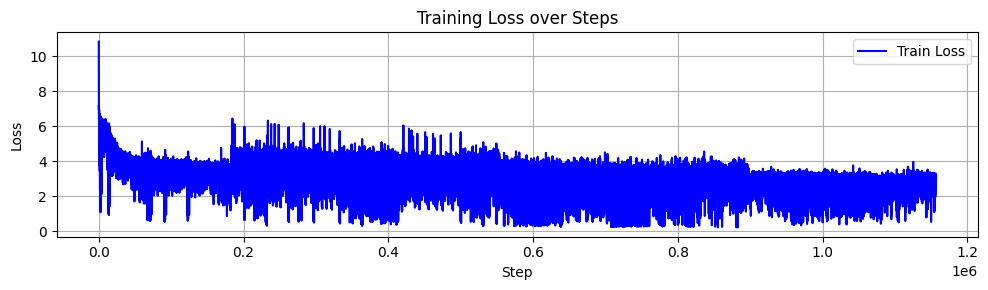

Number of steps: 1156735


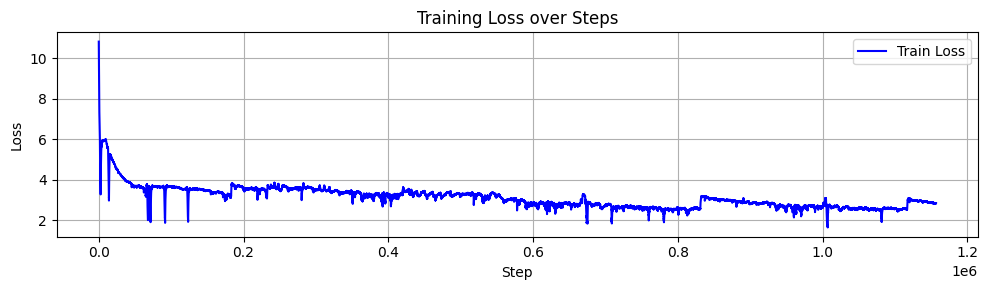

Number of steps: 1156735


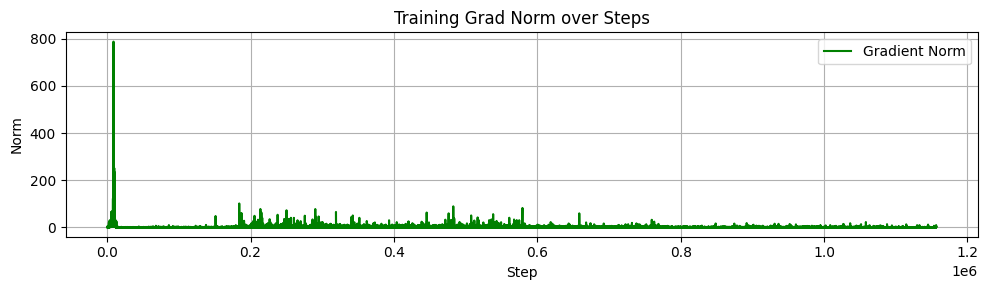

In [ ]:
trainer = Trainer(config)
tester = Tester(config)
t, g = trainer.load_train_metrics("checkpoints/epoch4/train-metrics-epoch-3-final.pt")
t_ema = tester.to_ema(t)
#v = trainer.load_val_metrics()
tester.plot_train_loss(t)
tester.plot_train_loss(t_ema)
tester.plot_train_grad_norm(g)
#tester.plot_val_loss(v)
#tester.test(model, dataset_test)

In [ ]:
tester = Tester(config)
#tester.load_parameters(model)
tester.load_parameters(model, file_name="checkpoints/epoch4/checkpoint-interruptted.pt")

Checkpoint loaded: Epoch 4, Step 52573, Train Loss EMA 2.62, Dataset Position 1396380


In [ ]:
#config = Config()
tester = Tester(config)
tester.do_smoke_test(model, temperature=0.7)

Prompt: Anarchism is a    =>    Anarchism is a political theory that is a form of social Darwinism.

Anarchism may also refer to
Prompt: The capital of France is    =>    The capital of France is an important source of income and capital, for the French economy. It is the second largest French economy
Prompt: Paris is    =>    Paris is a French pop band, composed of singer-songwriter Jean-Philippe Dauphin,
Prompt: The Great Wall of China is located in    =>    The Great Wall of China is located in the southern portion of the Tibetan Plateau. It is  high, and  wide.


Prompt: Mount Everest is located in    =>    Mount Everest is located in the central part of the Himalayas at the foothills of the Himalayas. The mountain
Prompt: The theory of relativity was developed by    =>    The theory of relativity was developed by the British physicist Robert B. W. Wilson (1912–1997), who became a leading proponent
Prompt: Albert Einstein developed the theory of    =>    Albert Einstein developed t

In [5]:
# Deployment
!pip install huggingface_hub
!apt-get install git-lfs -qq
!git lfs install
from huggingface_hub import notebook_login
from huggingface_hub import HfApi
from huggingface_hub import Repository

Git LFS initialized.


In [6]:
notebook_login()

In [7]:
# Deployment
api = HfApi()
model_name = "TinyLM-Base"
model_dir = "TinyLM-Base-Repo"
repo_id = f"btesh/{model_name}"

repo_url = api.create_repo(repo_id=repo_id, exist_ok=True)

print("Repository URL:", repo_url)

os.makedirs(model_dir, exist_ok=True)

Repository URL: https://huggingface.co/btesh/TinyLM-Base


In [8]:
!git clone https://huggingface.co/btesh/TinyLM-Base TinyLM-Base-Repo

Cloning into 'TinyLM-Base-Repo'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (3/3), 1.05 KiB | 1.05 MiB/s, done.


In [9]:
torch.save(model.state_dict(), f'{model_dir}/{model_name}-weights.bin')

In [10]:
repo = Repository(
    local_dir=model_dir,
    use_auth_token=True
)

repo.push_to_hub(commit_message="Initial model upload")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)


Upload file TinyLM-Base-weights.bin:   0%|          | 1.00/518M [00:00<?, ?B/s]

To https://huggingface.co/btesh/TinyLM-Base
   d54ed00..7049898  main -> main

   d54ed00..7049898  main -> main



'https://huggingface.co/btesh/TinyLM-Base/commit/7049898bef7524a16f5e5e7404bc5d2f5186dc3c'